# First evaluation insights

**Inputs:**
* Network: Airtel
* Service: fw1chain, fw2chain, fw3chain
* Sources: source0-9

In [61]:
%matplotlib inline
import glob
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# network prefix to filter results
prefix = 'Airtel'

Airtel is a medium-large network with nodes far away from each other. This leads to high link delays and lower impact of rounding link delays to full integers, which was a problem with the very dense Colt network.

![Airtel](http://topology-zoo.org/maps/Airtel.jpg)

In [62]:
# load simulation results and calculate RTT (from bjointsp)
sim_results = glob.glob('bjointsp/{}*.yaml'.format(prefix))
sim_delays = []
for result_file in sim_results:
    with open(result_file, 'r') as f:
        result = yaml.load(f)

        # one-way = RTT/2
        result['chain_rtt'] = result['metrics']['total_delay'] * 2
        for delay in result['metrics']['delays']:
            delay['rtt'] = delay['delay'] * 2

        sim_delays.append(result)

In [63]:
# load corresponding emulation results and calculate RTT
emu_results = glob.glob('bjointsp/emulation/{}*.yaml'.format(prefix))
emu_delays = []
for result_file in emu_results:
    with open(result_file, 'r') as f:
        result = yaml.load(f)

        # chain delays = httping = TCP handshake = 2x RTT
        result['chain_rtt'] = result['chain_delay']['delay'] / 2

        # vnf delays = ping = RTT
        for delay in result['delays']:
            delay['rtt'] = delay['delay']

        emu_delays.append(result)
        # TODO: also store std (how is std affected, when mean/2?)

Combine the results from emulation and simulation:
1. Sort and match results for chain and inter-VNF delays
2. Create ordered data frame for easier comparison and evaluation

In [64]:
# create empty data frames
input_cols = ['network', 'num_nodes', 'num_edges', 'service', 'num_vnfs', 'sources', 'num_sources', 'model']
chain_df = pd.DataFrame(columns=input_cols + ['sim_rtt', 'emu_rtt'])
vnf_df = pd.DataFrame(columns=input_cols + ['src', 'dest', 'sim_rtt', 'emu_rtt'])
chain_index = 0
vnf_index = 0

# match and sort chain and inter-VNF RTTs and insert into data frames
for emu in emu_delays:
    for sim in sim_delays:
        # match chain delays (same input: network, service, sources)
        if emu['input']['network'].endswith(sim['input']['network']) \
                and emu['input']['service'].endswith(sim['input']['service']) \
                and emu['input']['sources'].endswith(sim['input']['sources']):
            
            # insert into data frame
            inputs = [sim['input']['network'], sim['input']['num_nodes'], sim['input']['num_edges'], 
                      sim['input']['service'], sim['input']['num_vnfs'],
                      sim['input']['sources'], sim['input']['num_sources'], sim['input']['model']]
            # somehow the simulation RTT needs to be cast to float explicitly
            chain_df.loc[chain_index] = inputs + [float(sim['chain_rtt']), emu['chain_rtt']]
            chain_index += 1

            # match inter-VNF RTTs (same input + src, dest)
            for emu_vnf in emu['delays']:
                for sim_vnf in sim['metrics']['delays']:
                    if emu_vnf['src'] == sim_vnf['src'] and emu_vnf['dest'] == sim_vnf['dest']:
                        vnf_df.loc[vnf_index] = inputs + [sim_vnf['src'], sim_vnf['dest'], float(sim_vnf['rtt']), emu_vnf['rtt']]
                        vnf_index += 1

In [65]:
# add RTT difference (as rtt_diff): emu_rtt - sim_rtt
chain_df['rtt_diff'] = chain_df['emu_rtt'] - chain_df['sim_rtt']

print(chain_df.describe())
chain_df.head()

          sim_rtt     emu_rtt   rtt_diff
count   30.000000   30.000000  30.000000
mean    55.733333   57.373333   1.640000
std     33.891239   34.203400   0.556993
min      6.000000    6.950000   0.950000
25%     34.500000   36.150000   1.000000
50%     50.000000   51.975000   1.650000
75%     72.500000   74.312500   2.300000
max    138.000000  140.300000   2.400000


,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,model,sim_rtt,emu_rtt,rtt_diff
0,Airtel.graphml,16,37,fw1chain.yaml,3,source0.yaml,1,bjointsp-heuristic,60.0,61.00,1.00
1,Airtel.graphml,16,37,fw1chain.yaml,3,source1.yaml,1,bjointsp-heuristic,6.0,6.95,0.95
2,Airtel.graphml,16,37,fw1chain.yaml,3,source2.yaml,1,bjointsp-heuristic,44.0,45.00,1.00
3,Airtel.graphml,16,37,fw1chain.yaml,3,source3.yaml,1,bjointsp-heuristic,64.0,65.00,1.00
4,Airtel.graphml,16,37,fw1chain.yaml,3,source4.yaml,1,bjointsp-heuristic,42.0,42.95,0.95


In [66]:
vnf_df['rtt_diff'] = vnf_df['emu_rtt'] - vnf_df['sim_rtt']

print(vnf_df.describe())
vnf_df.head()

         sim_rtt    emu_rtt   rtt_diff
count  90.000000  90.000000  90.000000
mean   18.577778  18.914211   0.336433
std    21.130402  21.374561   0.246943
min     0.000000   0.074000   0.074000
25%     0.000000   0.081250   0.081250
50%     6.000000   6.251000   0.251000
75%    30.000000  30.484500   0.484500
max    64.000000  64.836000   0.836000


,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,model,src,dest,sim_rtt,emu_rtt,rtt_diff
0,Airtel.graphml,16,37,fw1chain.yaml,3,source0.yaml,1,bjointsp-heuristic,vnf_user,vnf_fw1,0.0,0.080,0.080
1,Airtel.graphml,16,37,fw1chain.yaml,3,source0.yaml,1,bjointsp-heuristic,vnf_fw1,vnf_web,60.0,60.787,0.787
2,Airtel.graphml,16,37,fw1chain.yaml,3,source1.yaml,1,bjointsp-heuristic,vnf_user,vnf_fw1,0.0,0.082,0.082
3,Airtel.graphml,16,37,fw1chain.yaml,3,source1.yaml,1,bjointsp-heuristic,vnf_fw1,vnf_web,6.0,6.236,0.236
4,Airtel.graphml,16,37,fw1chain.yaml,3,source2.yaml,1,bjointsp-heuristic,vnf_user,vnf_fw1,0.0,0.083,0.083


## Chain RTT

Let's start by analyzing the RTT of the whole chain.

In [67]:
# create helper df with separate rows for each RTT and a type (sim or emu)
# for easier plotting later
chain_sim_df = chain_df[input_cols].copy()
chain_sim_df['rtt'] = chain_df['sim_rtt']
chain_sim_df['type'] = 'sim'

chain_emu_df = chain_df[input_cols].copy()
chain_emu_df['rtt'] = chain_df['emu_rtt']
chain_emu_df['type'] = 'emu'

chain_df2 = pd.concat([chain_sim_df, chain_emu_df])

Text(0.5,1,'Chain RTT comparison')

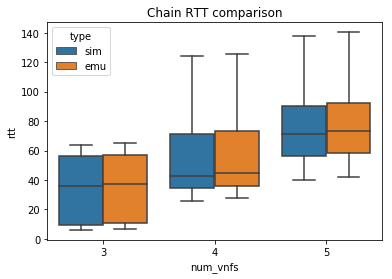

In [68]:
# chain delay boxplots
sns.boxplot(x='num_vnfs', y='rtt', hue='type', data=chain_df2).set_title('Chain RTT comparison')

Text(0.5,1,'Chain RTT difference')

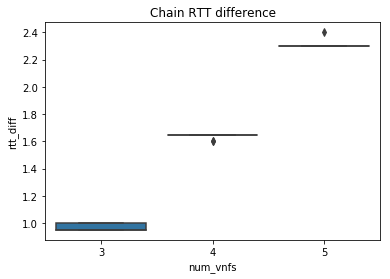

In [69]:
sns.boxplot(x='num_vnfs', y='rtt_diff', data=chain_df).set_title('Chain RTT difference')

Chain delays seem to be very similar comparing simulation and emulation (upper figure). 

But when looking at the difference in RTT (lower figure), the emulation delay is clearly higher than the simulation delay. And the difference between the two increases with increasing chain length. There is surprisingly little deviation in rtt_diff for each chain length.

## Inter-VNF RTT
Let's do the same for inter-VNF delays/RTTs.

In [70]:
vnf_sim_df = vnf_df[input_cols + ['src', 'dest']].copy()
vnf_sim_df['rtt'] = vnf_df['sim_rtt']
vnf_sim_df['type'] = 'sim'

vnf_emu_df = vnf_df[input_cols + ['src', 'dest']].copy()
vnf_emu_df['rtt'] = vnf_df['emu_rtt']
vnf_emu_df['type'] = 'emu'

vnf_df2 = pd.concat([vnf_sim_df, vnf_emu_df])

Text(0.5,1,'Inter-VNF RTT comparison')

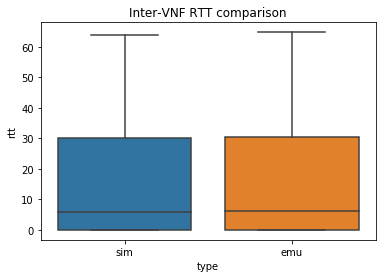

In [71]:
sns.boxplot(x='type', y='rtt', data=vnf_df2).set_title('Inter-VNF RTT comparison')

Text(0.5,1,'Inter-VNF RTT difference')

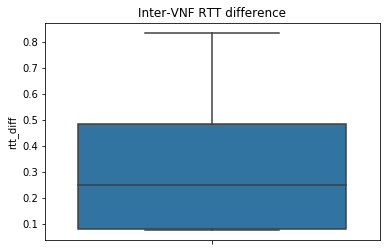

In [72]:
sns.boxplot(y='rtt_diff', data=vnf_df).set_title('Inter-VNF RTT difference')

**Upper**: Again, very similar inter-VNF RTTs in simulation and emulation.

**Lower**: Here, the difference is much smaller than it was in whole chains (less than 1 ms). However, the spread is much higher than for chains. We should analyze that further.